# Neural Nets and Tabular Data: Kaggle Rossmann Competition

Kaggle's [Rossmann competition](https://www.kaggle.com/c/rossmann-store-sales) was notable because it was one of the first time that a predictive model based solely on a deep neural network scored among the top 3 places on a kaggle competition.

The [third place entry](https://www.kaggle.com/c/rossmann-store-sales/discussion/17974) used simple features and only a single neural network. The innovation that propelled them to 3rd place was their invention of category embeddings (also called entity embeddings): http://arxiv.org/abs/1604.06737

Entity embeddings is just another way of encoding categorical variables, except that instead of each value (cardinality) for a particular category being represented by a single numerical value, it is instead represented by a vector with a length that can be set by the practitioner. The weights in these vectors are also trainable by the neural network. Overall, this approach is similar in concept to the idea of word embeddings often used in NLP.

The goal of the Rossmann competition was to predict future sales of stores, using promotion and competitor data.

The beauty of using neural networks is that we can obtain results commensurate to more traditional methods, but without spending all the time on feature engineering and acquiring extensive domain knowledge.

In this notebook, we'll implement a solution that's very nearly identical to the 3rd place solution referenced above.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# Get nicer looking graphs for retina displays
%config InlineBackend.figure_format = 'retina'
from fastai import *
from fastai.tabular import *

## Data Prep / Feature Engineering

In addition to the competition data, the 3rd place winners also used a few external datasets. We'll first download all the data we'll need from http://files.fast.ai/part2/lesson14/rossmann.tgz, and then clean and join features from the various data tables as appropriate

In [2]:
path = Config.data_path()/'rossmann/'
path.mkdir(exist_ok=True)
path

PosixPath('/home/jupyter/.fastai/data/rossmann')

In [12]:
# Download and untar
url = 'http://files.fast.ai/part2/lesson14/rossmann'
fname = download_data(url, fname=Config.data_path()/'rossmann.tgz')

In [14]:
tarfile.open(fname, 'r:gz').extractall(path)

First, we'll load all the data tables.

In [199]:
table_names = ['train', 'store', 'store_states', 'state_names', 'googletrend', 'weather', 'test']
tables = [pd.read_csv(path/f'{name}.csv', low_memory=False) for name in table_names]
# Create variables for each dataframe
train, store, store_states, state_names, googletrend, weather, test = tables
len(train), len(test)

(1017209, 41088)

In [200]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [201]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


Turn state holidays into booleans in order to make them more convenient for modeling.

In [202]:
train['StateHoliday'] = train['StateHoliday'] != '0'

In [203]:
train['StateHoliday'].head()

0    False
1    False
2    False
3    False
4    False
Name: StateHoliday, dtype: bool

In [204]:
test['StateHoliday'] = test['StateHoliday'] != '0'

We'll create a function to join data tables on specific columns. By default, we'll be doing a left outer join of `right` on the `left` arguments.

A left outer join preserves all rows in the `left` data table, regardless of whether they are present in the `right` data table. If a row in the `left` table is missing from the `right` table, in the newly merged table, its entries for each column originally occurring in thr right table will be null.

Any rows that exist only in the `right` table but not in the `left` table will not be included in the newly merged table.

In Pandas, joins are done using the `merge` method. The `suffixes` argument describes the naming convention for duplicate columns (if the `left_on` and `right_on` arguments are identical column names). We will leave duplicate column names on the left untouched (append an empty string ''), and only append \'\_y\' to those on the right.

In [205]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on,
                      suffixes=('', suffix))

Let's join weather data to state names.

In [206]:
weather.head()

,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268


In [207]:
state_names.head()

,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE
3,Brandenburg,BB
4,Bremen,HB


In [208]:
weather = join_df(weather, state_names, 'file', 'StateName')

In [209]:
weather.head()

,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,State
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,4.0,39,26,58.0,5.08,6.0,Rain,215,NordrheinWestfalen,NW
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,10.0,24,16,NaN,0.00,6.0,Rain,225,NordrheinWestfalen,NW
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,2.0,26,21,NaN,1.02,7.0,Rain,240,NordrheinWestfalen,NW
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,2.0,23,14,NaN,0.25,7.0,Rain,263,NordrheinWestfalen,NW
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,3.0,16,10,NaN,0.00,7.0,Rain,268,NordrheinWestfalen,NW


We need to re-format the `googletrend` table so that its dates and state names are displayed consistently with the rest of our tables.

In [210]:
googletrend.head()

,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67


In [211]:
googletrend['Date'] = googletrend['week'].str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend['file'].str.split('_', expand=True)[2]

In [212]:
googletrend.head()

,file,week,trend,Date,State
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96,2012-12-02,SN
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95,2012-12-09,SN
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91,2012-12-16,SN
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48,2012-12-23,SN
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67,2012-12-30,SN


In the `googletrend` table, some state names are displayed as `NI`, however in all other tables the corresponding name appears as `HB,NI`.

We will use the Pandas function `.loc[rows, cols]` to index into the pertinent cells and change the entry from `NI` to `HB,NI`.

In [213]:
googletrend.loc[googletrend['State'] == 'NI', 'State'] = 'HB,NI'

In [214]:
googletrend.loc[googletrend['State'] == 'HB,NI'].head()

,file,week,trend,Date,State
1184,Rossmann_DE_NI,2012-12-02 - 2012-12-08,76,2012-12-02,"HB,NI"
1185,Rossmann_DE_NI,2012-12-09 - 2012-12-15,73,2012-12-09,"HB,NI"
1186,Rossmann_DE_NI,2012-12-16 - 2012-12-22,84,2012-12-16,"HB,NI"
1187,Rossmann_DE_NI,2012-12-23 - 2012-12-29,53,2012-12-23,"HB,NI"
1188,Rossmann_DE_NI,2012-12-30 - 2013-01-05,51,2012-12-30,"HB,NI"


For many, if not most tabular data problems (with the exception of financial investment data like stock prices), constructing several categorical variables from time-series dates performs just as well if not better than using an RNN to find patterns.

This next function will take a date as input, and create several categorical features that describe for the date in question what day of the week it was, what month, etc.

In [215]:
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld=df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64
    
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
            'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [216]:
add_datepart(weather, 'Date', drop=False)
add_datepart(googletrend, 'Date', drop=False)
add_datepart(train, 'Date', drop=False)
add_datepart(test, 'Date', drop=False)

In [217]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,1,5,2015-07-31,5263,555,1,1,False,1,2015,...,31,4,212,True,False,False,False,False,False,1438300800
1,2,5,2015-07-31,6064,625,1,1,False,1,2015,...,31,4,212,True,False,False,False,False,False,1438300800
2,3,5,2015-07-31,8314,821,1,1,False,1,2015,...,31,4,212,True,False,False,False,False,False,1438300800
3,4,5,2015-07-31,13995,1498,1,1,False,1,2015,...,31,4,212,True,False,False,False,False,False,1438300800
4,5,5,2015-07-31,4822,559,1,1,False,1,2015,...,31,4,212,True,False,False,False,False,False,1438300800


The `googletrend` table has a whole category just for Germany, which we will also use.

In [218]:
trend_de = googletrend[googletrend['file'] == 'Rossmann_DE']

In [219]:
trend_de.head()

,file,week,trend,Date,State,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
148,Rossmann_DE,2012-12-02 - 2012-12-08,77,2012-12-02,None,2012,12,48,2,6,337,False,False,False,False,False,False,1354406400
149,Rossmann_DE,2012-12-09 - 2012-12-15,76,2012-12-09,None,2012,12,49,9,6,344,False,False,False,False,False,False,1355011200
150,Rossmann_DE,2012-12-16 - 2012-12-22,85,2012-12-16,None,2012,12,50,16,6,351,False,False,False,False,False,False,1355616000
151,Rossmann_DE,2012-12-23 - 2012-12-29,59,2012-12-23,None,2012,12,51,23,6,358,False,False,False,False,False,False,1356220800
152,Rossmann_DE,2012-12-30 - 2013-01-05,61,2012-12-30,None,2012,12,52,30,6,365,False,False,False,False,False,False,1356825600


Now it's time to join all of our data tables into one single dataframe.

The best approach is to perform a left outer join, and then check for Null values (rows that are in the `right` table but not in the `left`) after joining.

We could do an *inner join* and get the exact same results to the above method. However, this would require the assumption that all records are complete and match on the column name I desire. 

If, however, a mistake was made, or my assumption that all records were complete was incorrect, performing an outer join followed by a null-check will catch this. 

In [220]:
store = join_df(store, store_states, 'Store')
len(store[store['State'].isnull()])

0

So far so good, there are no Null entries in the `State` column in the joined table.

Let's do the rest:

In [221]:
joined = join_df(train, store, 'Store')
joined_test = join_df(test, store, 'Store')
len(joined[joined['StoreType'].isnull()]), len(joined_test[joined_test['StoreType'].isnull()])

(0, 0)

In [222]:
joined = join_df(joined, googletrend, ['State', 'Year', 'Week'])
joined_test = join_df(joined_test, googletrend, ['State', 'Year', 'Week'])
len(joined[joined['trend'].isnull()]), len(joined_test[joined_test['trend'].isnull()])

(0, 0)

In [223]:
joined = joined.merge(trend_de, 'left', ['Year', 'Week'], suffixes=('','_DE'))
joined_test = joined_test.merge(trend_de, 'left', ['Year', 'Week'], suffixes=('','_DE'))
len(joined[joined['trend_DE'].isnull()]), len(joined_test[joined_test['trend_DE'].isnull()])

(0, 0)

In [224]:
joined = join_df(joined, weather, ['State', 'Date'])
joined_test = join_df(joined_test, weather, ['State', 'Date'])
len(joined[joined['Mean_TemperatureC'].isnull()]), len(joined_test[joined_test['Mean_TemperatureC'].isnull()])

(0, 0)

Now drop any columns added from the datatables that were duplicates.

In [225]:
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

In [226]:
joined.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName
0,1,5,2015-07-31,5263,555,1,1,False,1,2015,...,15.0,10.0,24,11,NaN,0.0,1.0,Fog,13,Hessen
1,2,5,2015-07-31,6064,625,1,1,False,1,2015,...,10.0,10.0,14,11,NaN,0.0,4.0,Fog,309,Thueringen
2,3,5,2015-07-31,8314,821,1,1,False,1,2015,...,14.0,10.0,14,5,NaN,0.0,2.0,Fog,354,NordrheinWestfalen
3,4,5,2015-07-31,13995,1498,1,1,False,1,2015,...,10.0,10.0,23,16,NaN,0.0,6.0,NaN,282,Berlin
4,5,5,2015-07-31,4822,559,1,1,False,1,2015,...,10.0,10.0,14,11,NaN,0.0,4.0,NaN,290,Sachsen


In [227]:
joined_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName
0,1,1,4,2015-09-17,1.0,1,False,0,2015,9,...,12.0,7.0,29,14,NaN,7.11,6.0,Rain,191,Hessen
1,2,3,4,2015-09-17,1.0,1,False,0,2015,9,...,12.0,8.0,37,26,53.0,3.05,6.0,Rain,187,NordrheinWestfalen
2,3,7,4,2015-09-17,1.0,1,False,0,2015,9,...,10.0,2.0,29,14,45.0,0.76,5.0,Rain,209,SchleswigHolstein
3,4,8,4,2015-09-17,1.0,1,False,0,2015,9,...,10.0,2.0,29,14,45.0,0.76,5.0,Rain,209,SchleswigHolstein
4,5,9,4,2015-09-17,1.0,1,False,0,2015,9,...,12.0,8.0,37,26,53.0,3.05,6.0,Rain,187,NordrheinWestfalen


Now it's time to fill `NAN` values. Our strategy here will simply be to fill them with an arbitrary signal value that doesn't otherwise appear in the data.

In [228]:
for df in (joined, joined_test):
    df['CompetitionOpenSinceYear'] = df['CompetitionOpenSinceYear'].fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df['CompetitionOpenSinceMonth'].fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df['Promo2SinceYear'].fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df['Promo2SinceWeek'].fillna(1).astype(np.int32)

Now we'll create the `CompetitionOpenSince` and `CompetitionDaysOpen` features.

In [229]:
for df in (joined, joined_test):
    df['CompetitionOpenSince'] = pd.to_datetime(dict(year=df['CompetitionOpenSinceYear'],
                                                     month=df['CompetitionOpenSinceMonth'], day=15))
    df['CompetitionDaysOpen'] = df['Date'].subtract(df['CompetitionOpenSince']).dt.days

Also important to identify and replace erroneous or outlier data. Specifically, we don't want values for `CompetitionDaysOpen` that are negative, or that are too large.

In [230]:
for df in (joined, joined_test):
    df.loc[df['CompetitionDaysOpen'] < 0, 'CompetitionDaysOpen'] = 0
    df.loc[df['CompetitionOpenSinceYear'] < 1990, 'CompetitionDaysOpen'] = 0

We'll also add a `CompetitionMonthsOpen` column, and limit the maximum number of months to 24, so that we don't have too many unique categories for this feature.

In [231]:
for df in (joined, joined_test):
    df['CompetitionMonthsOpen'] = df['CompetitionDaysOpen'] // 30
    df.loc[df['CompetitionMonthsOpen'] > 24, 'CompetitionMonthsOpen'] = 24
joined['CompetitionMonthsOpen'].unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,  1, 14, 20,  8, 18,  6, 21,  5])

We'll follow a similar process for Promo dates.

In [232]:
# Uncomment, if package not yet installed:
# ! pip install isoweek

In [233]:
from isoweek import Week
for df in (joined, joined_test):
    df['Promo2Since'] = pd.to_datetime(df.apply(lambda x: Week(
        x['Promo2SinceYear'], x['Promo2SinceWeek']).monday(), axis=1).astype(pd.datetime))
    df['Promo2Days'] = df['Date'].subtract(df['Promo2Since']).dt.days

In [234]:
for df in (joined, joined_test):
    df.loc[df['Promo2Days'] < 0, 'Promo2Days'] = 0
    df.loc[df['Promo2SinceYear'] < 1990, 'Promo2Days'] = 0
    df['Promo2Weeks'] = df['Promo2Days'] // 7
    df.loc[df['Promo2Weeks'] < 0, 'Promo2Weeks'] = 0
    df.loc[df['Promo2Weeks'] > 25, 'Promo2Weeks'] = 25


In [235]:
for df in (joined, joined_test):
    print(df['Promo2Weeks'].unique())
    print(len(df['Promo2Weeks'].unique()))

[ 0 25 17  8 13 24 16  7 12 23 15  6 11 22 14  5 10 21  4  9 20  3 19  2 18  1]
26
[ 0 25 24 15 20 23 14 19 22 13 18 21 12 17 11 16 10  9  8]
19


Let's save our current working versions of the train and test dataframes, so that if we want to take a break and resume work, we won't have to re-run all the above cells.

In [236]:
joined.to_pickle(path/'joined')
joined_test.to_pickle(path/'joined_test')

## Durations

The final phase of data prep will be to extract time series data that explains relationships across rows, as opposed to columns. Namely, we'll create several features that express *durations* of time. For example:

* Running averages
* Time until next event
* Time since last event

We will create a function called `get_elapsed`, which will perform cumulative counting across a sorted dataframe. given a particular `fld` to monitor, the function will start tracking the time that has elapsed since the last occurrence of that field. When the field is seen again, the counter will be reset to zero.

In [237]:
def get_elapsed(fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []
    
    for s,v,d in zip(df['Store'].values, df[fld].values, df['Date'].values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    df[pre + fld] = res

We'll use these columns to apply this method:

In [238]:
columns = ['Date', 'Store', 'Promo', 'StateHoliday', 'SchoolHoliday']

In [239]:
df = train[columns].append(test[columns]) # Append the rows of train and test

In [240]:
df.head()

,Date,Store,Promo,StateHoliday,SchoolHoliday
0,2015-07-31,1,1,False,1
1,2015-07-31,2,1,False,1
2,2015-07-31,3,1,False,1
3,2015-07-31,4,1,False,1
4,2015-07-31,5,1,False,1


In the case of the `SchoolHoliday` column, we first sort by `Store`, and then by `Date`. Then we call `get_elapsed('SchoolHoliday', 'After')`.

This will then create a feature that, for each row, contains the number of days that have elapsed since the most recent school holiday.

If we then sort by `Store` and then again sort by `Date`, but this time in reverse direction, we can call `get_elapsed('SchoolHoliday, 'Before')` to produce a feature that for each row displays the number of days until the *next* school holiday.

In [241]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True,False])
get_elapsed(fld, 'Before')

We'll also do this for the `StateHoliday` and `Promo` columns.

In [242]:
for fld in ('StateHoliday', 'Promo'):
    df = df.sort_values(['Store', 'Date'])
    get_elapsed(fld, 'After')
    df = df.sort_values(['Store', 'Date'], ascending=[True, False])
    get_elapsed(fld, 'Before')

The final step is to set the null values from elapsed field calculations to 0. We set the active index to `Date` in order to do this.

In [243]:
df = df.set_index('Date')
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df[a] = df[a].fillna(0).astype(int)

In [244]:
df.head()

,Store,Promo,StateHoliday,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo
Date,,,,,,,,,,
2015-09-17,1,1,False,0,13,0,105,0,0,0
2015-09-16,1,1,False,0,12,0,104,0,0,0
2015-09-15,1,1,False,0,11,0,103,0,0,0
2015-09-14,1,1,False,0,10,0,102,0,0,0
2015-09-13,1,0,False,0,9,0,101,0,9,-1


The last group of features we'll create will contain rolling quantilies.

For each column that we care about, we'll use `sort_index()` to sort by date and count the number of events of interest for each store (using `groupby()`) over the subsequent week by using `rolling()` and `sum()`.

We'll also do the same once more, but going in the opposite direction.

In [245]:
bwd = df[['Store']+columns].sort_index().groupby('Store').rolling(7, min_periods=1).sum()
fwd = df[['Store']+columns].sort_index(ascending=False).groupby('Store').rolling(7, min_periods=1).sum()

Before merging these new rolling quantile features to our train and test tables, we need to drop the `Store` indices that were used to group the stores together.

In [246]:
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

Now we just need to reset the index of our dataframe, and we can merge the rolling quantile features to it.

In [247]:
df.reset_index(inplace=True)
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [248]:
df.drop(columns,1,inplace=True)

In [249]:
df.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-09-17,1,13,0,105,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
1,2015-09-16,1,12,0,104,0,0,0,0.0,0.0,3.0,0.0,0.0,2.0
2,2015-09-15,1,11,0,103,0,0,0,0.0,0.0,2.0,0.0,0.0,3.0
3,2015-09-14,1,10,0,102,0,0,0,0.0,0.0,1.0,0.0,0.0,4.0
4,2015-09-13,1,9,0,101,0,9,-1,0.0,0.0,0.0,0.0,0.0,4.0


Before merging all of our duration features back to our train and test tables, we'll first back them up.

In [250]:
df.to_pickle(path/'df')
df['Date'] = pd.to_datetime(df['Date'])

In [251]:
df.columns

Index(['Date', 'Store', 'AfterSchoolHoliday', 'BeforeSchoolHoliday',
       'AfterStateHoliday', 'BeforeStateHoliday', 'AfterPromo', 'BeforePromo',
       'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw',
       'StateHoliday_fw', 'Promo_fw'],
      dtype='object')

Now we'll load up the previously saved train and test tables, and merge the duration features to them.

In [252]:
joined = pd.read_pickle(path/'joined')
joined_test = pd.read_pickle(path/'joined_test')

In [253]:
joined = join_df(joined, df, ['Store', 'Date'])
joined_test = join_df(joined_test, df, ['Store', 'Date'])

One final wrinkle:

The third place winners made one decision that may have cost them a higher standing in the competition: they removed all instances where a store had zero sales, or was closed.

However, there are often periods where stores are temporatily closed for refurbishment. Before and after these periods, there are often spikes in sales. By ommitting this store closure information from their model, the original authors would have forfeited the ability of using this knowledge to predict the spikes that would precede and follow a closure period. 

Assuming that some meaningful signal was missed, it's possible that had the authors not done this, their final score would have been higher.

Nonetheless, I did perform one run-through where I left all the zero-value sales in the data, and trained. I found that the train/val loss didn't get much below 32 and 25, respectively. (I changed the zero value sales to 1e-6 so that I could take the log of them in order to compute loss.)

Therefore, I will follow the lead of the authors and remove all records where `Sales` were 0.

In [254]:
joined = joined[joined['Sales'] != 0]

Finally, let's back up the final versions of our train and test dataframes.

In [255]:
joined.reset_index(inplace=True)
joined_test.reset_index(inplace=True)
joined.to_pickle(path/'train_clean')
joined_test.to_pickle(path/'test_clean')

## Experimenting with a Sample of the Full Data Set

We will soon build a model to make predictions, but first, let's experiment with a smaller subset of the data.

In [256]:
train_df = pd.read_pickle(path/'train_clean')

In [257]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1


In [258]:
n = len(train_df); n

844338

In [268]:
idx = np.random.permutation(range(n))[:2000]
idx.sort()
small_train_df = train_df.iloc[idx[:1000]]
small_test_df = train_df.iloc[idx[1000:]]
small_cont_vars = ['CompetitionDistance', 'Mean_Humidity']
small_cat_vars = ['Store', 'DayOfWeek', 'PromoInterval']
small_train_df = small_train_df[small_cat_vars + small_cont_vars + ['Sales']]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]

In [269]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
220,221,5,NaN,13530.0,61,7750
764,766,5,NaN,9820.0,50,8537
1096,1099,5,"Jan,Apr,Jul,Oct",200.0,61,12074
1461,350,4,"Jan,Apr,Jul,Oct",8880.0,56,7772
2360,135,3,"Jan,Apr,Jul,Oct",5190.0,54,6673


In [270]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
429807,63,6,"Feb,May,Aug,Nov",3700.0,78,7034
430450,710,6,"Jan,Apr,Jul,Oct",1500.0,73,4213
431050,198,5,"Jan,Apr,Jul,Oct",290.0,48,3525
431253,401,5,"Jan,Apr,Jul,Oct",9200.0,36,6673
431437,586,5,NaN,250.0,65,12665


In [271]:
categorify = Categorify(small_cat_vars, small_cont_vars)
categorify(small_train_df)
categorify(small_test_df, test=True)

In [272]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
429807,63.0,6,"Feb,May,Aug,Nov",3700.0,78,7034
430450,710.0,6,"Jan,Apr,Jul,Oct",1500.0,73,4213
431050,198.0,5,"Jan,Apr,Jul,Oct",290.0,48,3525
431253,401.0,5,"Jan,Apr,Jul,Oct",9200.0,36,6673
431437,NaN,5,NaN,250.0,65,12665


Note that if a particular value of a categorical variable is found only in the test set, but not the train set, the `Categorify()` function will set all entries in the test set containing that value to `NaN`.

In [273]:
small_train_df['PromoInterval'].cat.categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [274]:
small_train_df['PromoInterval'].cat.codes[:5]

220    -1
764    -1
1096    1
1461    1
2360    1
dtype: int8

In [275]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

In [276]:
small_train_df[small_train_df['CompetitionDistance_na'] == True]

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
242274,622,6,NaN,2400.0,84,2637,True
357738,879,4,"Feb,May,Aug,Nov",2400.0,66,2953,True


## Preparing the Full Data Set

In [277]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')
len(train_df), len(test_df)

(844338, 41088)

In [278]:
procs = [FillMissing, Categorify, Normalize]

In [279]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [280]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var, 'Date']].copy()

In [281]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

Let's set aside the validation set.

In [282]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [283]:
valid_idx = range(cut)

In [284]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

Finally, we'll create the databunch object that will be used to train and validate our model.

In [285]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                   .split_by_idx(valid_idx)
                   .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                   .databunch())

Storing the labels as a `FloatList` object prepares them for regression.

## Model

The Rossmann eval metric is root-mean percent squared error. But if we take the log of it, it's just like root mean squared error. So we can take the log of our y values and then use RMSE as our NN loss function.

Make sure to thus also convert y_range to log y_range:

In [286]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [287]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

The fastai library supports embedding dropout, which adds a dropout layer to the embeddings of the categorical variables.

In [288]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [289]:
len(data.train_ds.cont_names)

16

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


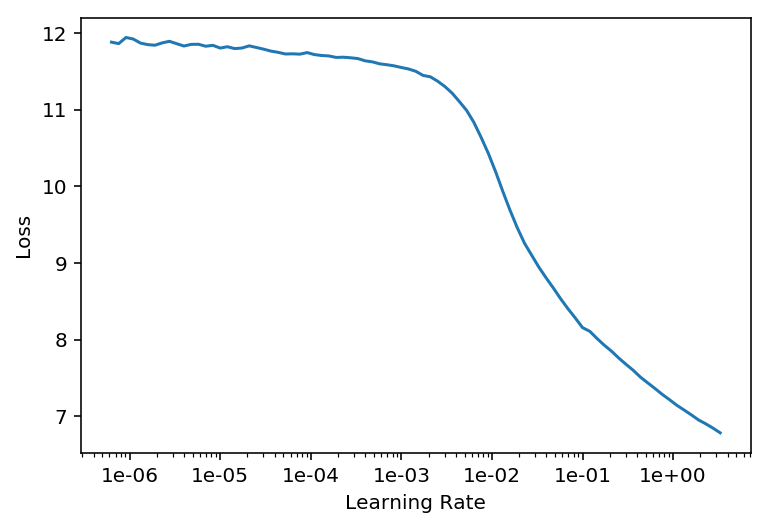

In [290]:
learn.lr_find()
learn.recorder.plot()

The normal fast.ai rule of thumb would be to pick an lr of 1e-2. However, after some experimentation, we found that 1e-3 worked better. 

It's always a good idea to follow the rule of thumb, and then experiment with some other variations.

In [291]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe
1,0.021660,0.018936,0.134316
2,0.018455,0.034160,0.141064
3,0.016751,0.016152,0.126056
4,0.012117,0.014582,0.114065
5,0.010602,0.011865,0.105436


In [292]:
learn.save('1')

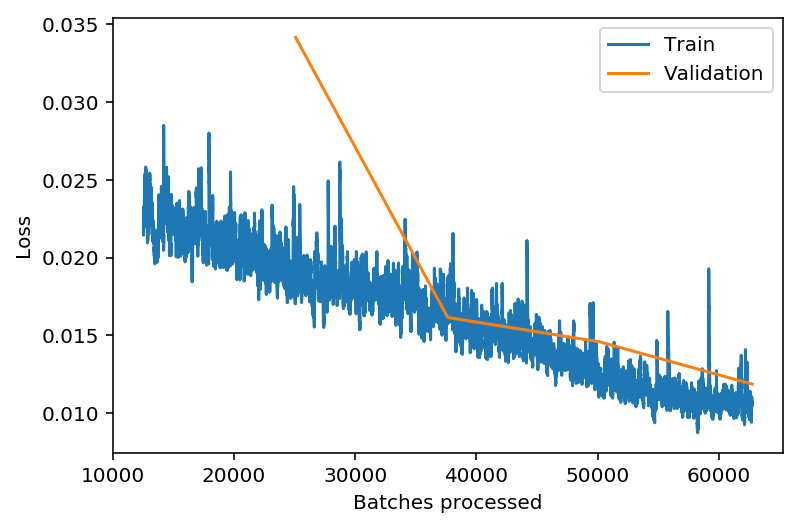

In [293]:
learn.recorder.plot_losses(last=-1)

In [299]:
learn.load('1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


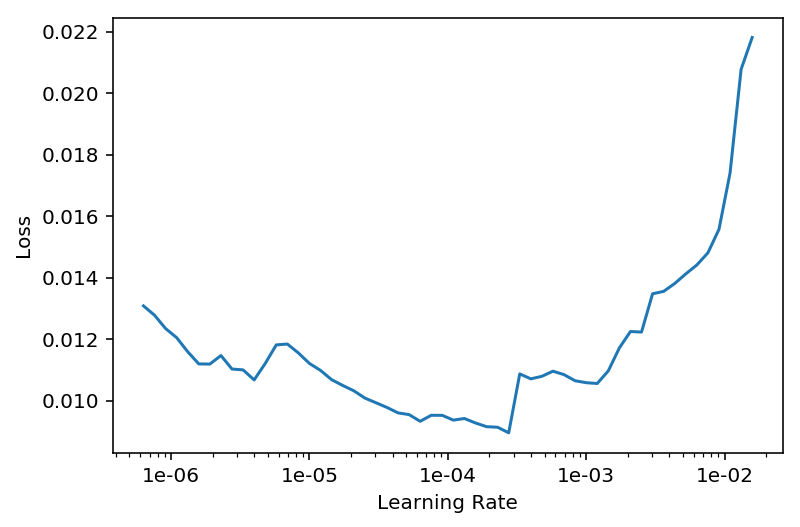

In [300]:
learn.lr_find()
learn.recorder.plot()

In [301]:
learn.fit_one_cycle(10, 3e-5)

epoch,train_loss,valid_loss,exp_rmspe
1,0.009425,0.012472,0.106555
2,0.010822,0.011597,0.104487
3,0.009835,0.011515,0.104281
4,0.010824,0.011799,0.104762
5,0.010408,0.012211,0.105337
6,0.009568,0.012025,0.105071
7,0.010796,0.011356,0.103288
8,0.009375,0.011280,0.102984
9,0.009468,0.012306,0.105289
10,0.009602,0.011949,0.104157


In [302]:
learn.save('final')

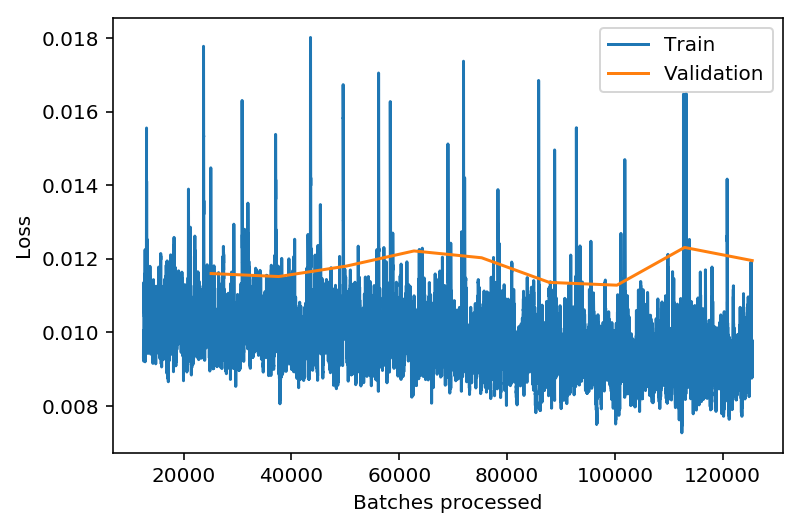

In [303]:
learn.recorder.plot_losses(last=-1)

After one more cycle of fine-tuning, we got down to a final score of `0.104` (with the best score `0.10298` after the 8th epoch). It so happens that 10th place in the competition was `0.108`.